In [26]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)
# pd.set_option('display.max_rows', 50)
import tabula
from pandasql import sqldf
import math
from scipy.stats import chi2
from scipy import stats
from matplotlib import pyplot as plt

------Function Layer---------

In [2]:
# individual data
func_layer = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\metaData_soybean_drought.xlsx', sheet_name = 'Function')

# whole genome data
xuan_2022 = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\whole genome data\incomplete\pathway\Xuan-2022\Xuan2022_iwgd.xlsx')

In [3]:
func_layer = pd.concat([func_layer, xuan_2022]).reset_index().drop(['index'], axis = 1)

In [4]:
# import template
template_a2v2 = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma2.0_mapping.txt', delimiter = '\t')
template_a1v11 = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma1.1_mapping.txt', delimiter = '\t')
template_a1v10 = pd.read_csv(r'C:\Users\edwar\Desktop\農藝\paper2\Glyma1.0_mapping.txt', delimiter = '\t')

In [5]:
# Wang et al., (2022) need score rescale
gene_data_score = func_layer[func_layer['score'].isna() == False].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'score', 'Pathways', 'gene_version', 'article_name']]
gene_data_p = func_layer[func_layer['p'].isna() == False].reset_index().drop(['index'], axis = 1)[['methodology', 'mapped_gene', 'p', 'score', 'Pathways', 'gene_version', 'article_name']]

In [6]:
# 處理 p 值資料
article_list_p = list(gene_data_p['article_name'].unique())
gene_score_data_p = pd.DataFrame()

count = 0
for article in article_list_p:
    gene_data_article_p = gene_data_p[gene_data_p['article_name'] == article]
    gene_list = list(gene_data_article_p['mapped_gene'].unique())
    
    for gene in gene_list:
        df_gene = gene_data_article_p[gene_data_article_p['mapped_gene'] == gene].reset_index().drop(['index'], axis = 1)
        
        if len(df_gene['mapped_gene']) > 1:
            df_gene_v1 = pd.DataFrame()
            p_values = list(df_gene['p'])
            p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
            df_gene_v1['mapped_gene'] = df_gene['mapped_gene'].unique()
            df_gene_v1['p'] = p_value
            df_gene_v1['Pathways'] = str(df_gene['Pathways'].unique()).replace('[', '').replace(']', '').replace("'", "")
            df_gene_v1['gene_version'] = df_gene['gene_version'].unique()
            df_gene_v1['article_name'] = df_gene['article_name'].unique()
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene_v1]).reset_index().drop(['index'], axis = 1)
            
        else:
            gene_score_data_p = pd.concat([gene_score_data_p, df_gene]).reset_index().drop(['index'], axis = 1)
            
    count += 1
    print(count)

1
2


In [7]:
gene_score_data_p.columns = ['methodology', 'gene', 'p', 'score', 'Pathways', 'gene_version', 'article_name']

In [8]:
# 判別各基因的顯著與否
p_thres = 0.05
gene_score_data_p['sig_flag'] = ''
gene_score_data_p['nonsig_flag'] = ''
gene_score_data_p.loc[(gene_score_data_p['p'] < p_thres), 'sig_flag'] = 1
gene_score_data_p.loc[(gene_score_data_p['p'] >= p_thres), 'sig_flag'] = 0

gene_score_data_p.loc[(gene_score_data_p['p'] < p_thres), 'nonsig_flag'] = 0
gene_score_data_p.loc[(gene_score_data_p['p'] >= p_thres), 'nonsig_flag'] = 1

In [10]:
# gene_list = list(gene_score_data_p['gene'].unique())
# gene_score_data_p_v1 = pd.DataFrame()

# count = 0
# for gene in gene_list:
#     df_gene = gene_score_data_p[gene_score_data_p['gene'] == gene].reset_index().drop(['index'], axis = 1)
#     df_gene['sig_flag_fv'] = ''
    
#     if df_gene['sig_flag'].sum() > df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '1'
    
#     elif df_gene['sig_flag'].sum() == df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '0'
        
#     elif df_gene['sig_flag'].sum() < df_gene['nonsig_flag'].sum():
#         df_gene['sig_flag_fv'] = '-1'
        
#     gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene]).reset_index().drop(['index'], axis = 1)
    
#     count += 1
#     if count % 100 == 0:
#         print(count)
    

100
200
300
400
500
600
700
800


In [30]:
# pd.DataFrame(gene_score_data_p['gene'].value_counts()[:400]).reset_index().rename(columns = {'gene':'counts', 'index':'gene'}).to_excel(r'C:\Users\edwar\Downloads\function_genes.xlsx', index = False)

In [10]:
set(gene_score_data_p['gene']) & set(gene_data_score['mapped_gene'])

set()

In [11]:
gene_list = list(gene_score_data_p['gene'].unique())
gene_score_data_p_v1 = pd.DataFrame()

count = 0
for gene in gene_list:
    df_gene = gene_score_data_p[gene_score_data_p['gene'] == gene].reset_index().drop(['index'], axis = 1)
    
    if len(df_gene['gene']) > 1:
        df_gene_v1 = pd.DataFrame()
        p_values = list(df_gene['p'])
        p_value = stats.combine_pvalues(p_values, method = 'fisher')[1]
        df_gene_v1['gene'] = df_gene['gene'].unique()
        df_gene_v1['p'] = p_value
#         df_gene_v1['Pathways'] = df_gene['Pathways'].unique()
        df_gene_v1['gene_version'] = df_gene['gene_version'].unique()
        df_gene_v1['sig_flag'] = df_gene['sig_flag'].sum()
        df_gene_v1['nonsig_flag'] = df_gene['nonsig_flag'].sum()
        gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene_v1]).reset_index().drop(['index'], axis = 1)
    
    else:
        gene_score_data_p_v1 = pd.concat([gene_score_data_p_v1, df_gene[['gene', 'p', 'gene_version', 'sig_flag', 'nonsig_flag']]]).reset_index().drop(['index'], axis = 1)
        
    count += 1
    if count % 100 == 0:
        print(count)

100
200
300
400
500
600
700
800


In [12]:
gene_score_data_p_v1['score'] = -np.log10(gene_score_data_p_v1['p'])

In [13]:
gene_score_data_p_v1 = gene_score_data_p_v1.drop(['gene_version'], axis = 1)

(array([ 71., 380.,  41.,  88., 124.,  56.,   3.,   3.,  10.,   7.,   7.,
          3.,   0.,  26.,   0.,  12.,   1.,   0.,   0.,   7.]),
 array([ 1.4       ,  1.95810926,  2.51621851,  3.07432777,  3.63243703,
         4.19054628,  4.74865554,  5.3067648 ,  5.86487405,  6.42298331,
         6.98109257,  7.53920182,  8.09731108,  8.65542034,  9.21352959,
         9.77163885, 10.32974811, 10.88785736, 11.44596662, 12.00407588,
        12.56218513]),
 <a list of 20 Patch objects>)

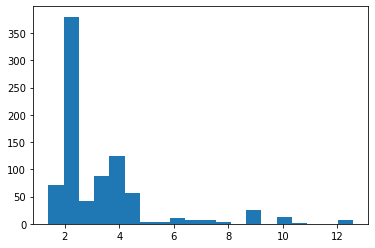

In [14]:
plt.hist(gene_score_data_p_v1['score'], bins = 20)

In [15]:
len(gene_score_data_p_v1[gene_score_data_p_v1['score'] > 12])

7

In [16]:
gene_score_data_p_v1

,gene,p,sig_flag,nonsig_flag,score
0,Glyma.12g073000,0.002179,2,0,2.661821
1,Glyma.14g040600,0.035481,1,0,1.450000
2,Glyma.16g042600,0.012589,1,0,1.900000
3,Glyma.07g184300,0.012589,1,0,1.900000
4,Glyma.17g186600,0.012589,1,0,1.900000
...,...,...,...,...,...
834,Glyma.20g230600,0.010091,1,0,1.996076
835,Glyma.20g230800,0.010091,1,0,1.996076
836,Glyma.20g236200,0.006556,1,0,2.183383
837,Glyma.u021800,0.006556,1,0,2.183383


In [9]:
gene_data_score

,methodology,mapped_gene,p,score,Pathways,gene_version,article_name
0,functional networks,Glyma.02g005600,NaN,8.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
1,functional networks,Glyma.10g013300,NaN,8.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
2,functional networks,Glyma.01g198100,NaN,8.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
3,functional networks,Glyma.19g164600,NaN,10.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
4,functional networks,Glyma.11g126500,NaN,2.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
5,functional networks,Glyma.12g051100,NaN,2.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
6,functional networks,Glyma.09g247500,NaN,9.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
7,functional networks,Glyma.16g151500,NaN,11.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...
8,functional networks,Glyma.14g171500,NaN,10.0,NaN,2,Genome-Wide Identification of the AP2/ERF Gene...


In [18]:
# 處理 network score 資料
gene_data_score['score_new'] = ''
gene_data_score.loc[(gene_data_score['score'] >= 8), 'score_new'] = 3
gene_data_score.loc[(gene_data_score['score'] > 9), 'score_new'] = 4
gene_data_score.loc[(gene_data_score['score'] > 10), 'score_new'] = 4.5
gene_data_score.loc[(gene_data_score['score'] < 8), 'score_new'] = gene_data_score['score'] / 1.5
gene_data_score['sig_flag'] = 1
gene_data_score['nonsig_flag'] = 0

In [19]:
gene_data_score_v1 = gene_data_score[['mapped_gene', 'score_new', 'sig_flag', 'nonsig_flag']]

In [20]:
gene_data_score_v1 = gene_data_score_v1.rename(columns = {'mapped_gene':'gene', 'score_new':'score'})

In [22]:
gene_score_data = pd.concat([gene_score_data_p_v1, gene_data_score_v1]).reset_index().drop(['index'], axis = 1)

In [25]:
gene_score_data['score'] = gene_score_data['score'].astype(float)

In [26]:
gene_score_data['score'].describe()

count    848.000000
mean       3.234491
std        1.952184
min        1.333333
25%        2.023806
50%        2.395204
75%        3.723091
max       12.562185
Name: score, dtype: float64

In [45]:
gene_score_data

,gene,p,sig_flag,nonsig_flag,score
0,Glyma.12g073000,0.002179,2,0,2.661821
1,Glyma.14g040600,0.035481,1,0,1.450000
2,Glyma.16g042600,0.012589,1,0,1.900000
3,Glyma.07g184300,0.012589,1,0,1.900000
4,Glyma.17g186600,0.012589,1,0,1.900000
...,...,...,...,...,...
843,Glyma.11g126500,NaN,1,0,1.333333
844,Glyma.12g051100,NaN,1,0,1.333333
845,Glyma.09g247500,NaN,1,0,3.000000
846,Glyma.16g151500,NaN,1,0,4.500000


(array([  9.,  23., 180., 183.,  58.,   1.,  20.,  35.,  64.,  13.,  78.,
         23.,  25.,  45.,  12.,   1.,   0.,   4.,   1.,   0.,   1.,   4.,
          5.,   7.,   0.,   2.,   5.,   0.,   0.,   3.,   0.,   0.,   0.,
          0.,  26.,   0.,   0.,  12.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   7.]),
 array([ 1.33333333,  1.55791037,  1.78248741,  2.00706444,  2.23164148,
         2.45621851,  2.68079555,  2.90537259,  3.12994962,  3.35452666,
         3.57910369,  3.80368073,  4.02825777,  4.2528348 ,  4.47741184,
         4.70198887,  4.92656591,  5.15114295,  5.37571998,  5.60029702,
         5.82487405,  6.04945109,  6.27402813,  6.49860516,  6.7231822 ,
         6.94775923,  7.17233627,  7.39691331,  7.62149034,  7.84606738,
         8.07064441,  8.29522145,  8.51979849,  8.74437552,  8.96895256,
         9.19352959,  9.41810663,  9.64268367,  9.8672607 , 10.09183774,
        10.31641477, 10.54099181, 10.76556885, 10.99014588, 11.21472292,
 

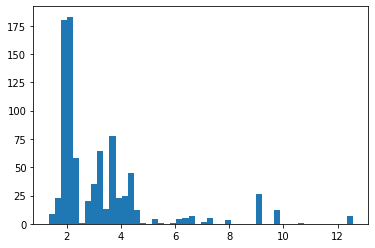

In [46]:
plt.hist(gene_score_data['score'], bins = 50)

In [51]:
len(gene_score_data[gene_score_data['score'] > 8])

46

In [57]:
cri1 = gene_score_data['score'] <= 2
cri2 = gene_score_data['score'] > 0
len(gene_score_data[cri1 & cri2])

198

# L1: 8 < x <= max in [5, 6] #about 46
# L2: 4 < x <= 8 in [4, 5] #about 110
# L3: 3 < x <= 4 in [3, 4] #about 198
# L4: 2 < x <= 3 in [2, 3] #about 291
# L5: 0 < x < 2 in [0, 2] #about 198

In [58]:
# data scaling function
def scale_score(x, upper_b, lower_b, max_val, min_val):
    scaling = (upper_b - lower_b) / (max_val - min_val)
    return (x - min_val) * scaling + lower_b

In [60]:
gene_score_data = gene_score_data.rename(columns = {'score':'score_raw'})

In [61]:
# L1 rescaling
upper_b = 6
lower_b = 5
max_val = gene_score_data['score_raw'].max()
min_val = 8
gene_score_data_L1 = gene_score_data[(gene_score_data['score_raw'] > min_val) & (gene_score_data['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_L1['score'] = gene_score_data_L1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [62]:
# L2 rescaling
upper_b = 5
lower_b = 4
max_val = 8
min_val = 4
gene_score_data_L2 = gene_score_data[(gene_score_data['score_raw'] > min_val) & (gene_score_data['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_L2['score'] = gene_score_data_L2['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [63]:
# L3 rescaling
upper_b = 4
lower_b = 3
max_val = 4
min_val = 3
gene_score_data_L3 = gene_score_data[(gene_score_data['score_raw'] > min_val) & (gene_score_data['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_L3['score'] = gene_score_data_L3['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [64]:
# L4 rescaling
upper_b = 3
lower_b = 2
max_val = 3
min_val = 2
gene_score_data_L4 = gene_score_data[(gene_score_data['score_raw'] > min_val) & (gene_score_data['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_L4['score'] = gene_score_data_L4['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [65]:
# L5 rescaling
upper_b = 2
lower_b = 0
max_val = 2
min_val = 0
gene_score_data_L5 = gene_score_data[(gene_score_data['score_raw'] > min_val) & (gene_score_data['score_raw'] <= max_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_L5['score'] = gene_score_data_L5['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [66]:
gene_score_data = pd.concat([gene_score_data_L1, gene_score_data_L2, gene_score_data_L3, gene_score_data_L4, gene_score_data_L5]).reset_index().drop(['index'], axis = 1)

(array([ 32., 371.,  57.,  84.,  42., 172.,  22.,  22.,  38.,   8.]),
 array([1.33333333, 1.8       , 2.26666667, 2.73333333, 3.2       ,
        3.66666667, 4.13333333, 4.6       , 5.06666667, 5.53333333,
        6.        ]),
 <a list of 10 Patch objects>)

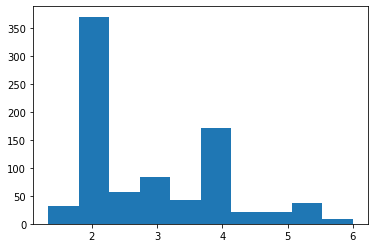

In [134]:
plt.hist(gene_score_data['score'])

------ import pathway results ------

In [73]:
gene_data_pathway = pd.read_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\Function\pathway_analysis_fv.xlsx')
gene_data_pathway = gene_data_pathway[['gene', 'score_total']]

(array([  65.,    0.,    0., 1323.,    0.,    0.,    0.,    0.,    0.,
           0., 1026.,    0.,    0.,  304.,    0.,    0.,   50.,    0.,
           0.,    0.,   38.,    0.,    0.,  366.,    0.,    0.,    0.,
           0.,    0.,    0.,    6.,    0.,    0.,    0.,    0.,    0.,
         227.,    0.,    0.,    0.,    0.,    0.,    0.,   17.,    0.,
           0.,    0.,    0.,    0.,   17.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ,
         4.3,  4.6,  4.9,  5.2,  5.5,  5.8,  6.1,  6.4,  6.7,  7. ,  7.3,
         7.6,  7.9,  8.2,  8.5,  8.8,  9.1,  9.4,  9.7, 10. , 10.3, 10.6,
        10.9, 11.2, 11.5, 11.8, 12.1, 12.4, 12.7, 13. , 13.3, 13.6, 13.9,
        14.2, 14.5, 14.8, 15.1, 15.4, 15.7, 16. ]),
 <a list of 50 Patch objects>)

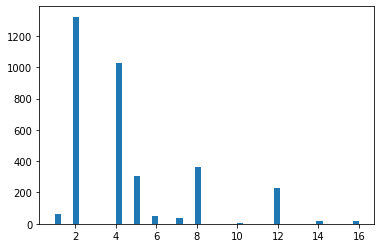

In [82]:
plt.hist(gene_data_pathway['score_total'], bins = 50)

# L1: 12 < x <= max in [5.5, 6] #about 34
# L2: 8.5 < x <= 12 in [4.5, 5.5] #about 233
# L3: 4 < x <= 8.3 in [3, 4.5] #about 758
# L4: 3 < x <= 4 in [2, 3] #about 1026
# L5: 0 < x <= 3 in [0, 2] #about 1388

In [126]:
# L1 rescaling
upper_b = 6
lower_b = 5.5
max_val = gene_data_pathway['score_total'].max()
min_val = 12
gene_data_pathway_L1 = gene_data_pathway[(gene_data_pathway['score_total'] <= max_val) & (gene_data_pathway['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_data_pathway_L1['score'] = gene_data_pathway_L1['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [127]:
# L2 rescaling
upper_b = 5.5
lower_b = 4.5
max_val = 12
min_val = 8.5
gene_data_pathway_L2 = gene_data_pathway[(gene_data_pathway['score_total'] <= max_val) & (gene_data_pathway['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_data_pathway_L2['score'] = gene_data_pathway_L2['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [128]:
# L3 rescaling
upper_b = 4.5
lower_b = 3
max_val = 8.3
min_val = 4
gene_data_pathway_L3 = gene_data_pathway[(gene_data_pathway['score_total'] <= max_val) & (gene_data_pathway['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_data_pathway_L3['score'] = gene_data_pathway_L3['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [129]:
# L4 rescaling
upper_b = 4
lower_b = 3
max_val = 3
min_val = 2
gene_data_pathway_L4 = gene_data_pathway[(gene_data_pathway['score_total'] <= max_val) & (gene_data_pathway['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_data_pathway_L4['score'] = gene_data_pathway_L4['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [130]:
# L5 rescaling
upper_b = 3
lower_b = 0
max_val = 2
min_val = 0
gene_data_pathway_L5 = gene_data_pathway[(gene_data_pathway['score_total'] <= max_val) & (gene_data_pathway['score_total'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_data_pathway_L5['score'] = gene_data_pathway_L5['score_total'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [132]:
gene_data_pathway = pd.concat([gene_data_pathway_L1, gene_data_pathway_L2, gene_data_pathway_L3, gene_data_pathway_L4, gene_data_pathway_L5]).reset_index().drop(['index'], axis = 1)

In [136]:
gene_data_pathway = gene_data_pathway.rename(columns = {'score':'score_sysbio'})
gene_score_data = gene_score_data.rename(columns = {'score':'score_datacoll'})

In [155]:
gene_score_data_v1 = gene_score_data[['gene', 'score_datacoll', 'sig_flag', 'nonsig_flag']].merge(gene_data_pathway[['gene', 'score_sysbio']], how = 'outer', on = ['gene'])

In [156]:
gene_score_data_v1['score_raw'] = gene_score_data_v1[['score_datacoll', 'score_sysbio']].sum(axis = 1)

In [157]:
gene_score_data_v1.loc[(gene_score_data_v1['sig_flag'].isna()), 'sig_flag'] = 0
gene_score_data_v1.loc[(gene_score_data_v1['nonsig_flag'].isna()), 'nonsig_flag'] = 0

In [158]:
gene_score_data_v1['score_raw'].describe()

count    3139.000000
mean        3.495273
std         1.160510
min         1.333333
25%         3.000000
50%         3.000000
75%         4.328072
max         8.903189
Name: score_raw, dtype: float64

(array([ 269.,  201., 1636.,  250.,  412.,  269.,   42.,   22.,   29.,
           9.]),
 array([1.33333333, 2.0903189 , 2.84730447, 3.60429004, 4.36127561,
        5.11826118, 5.87524675, 6.63223232, 7.38921789, 8.14620346,
        8.90318902]),
 <a list of 10 Patch objects>)

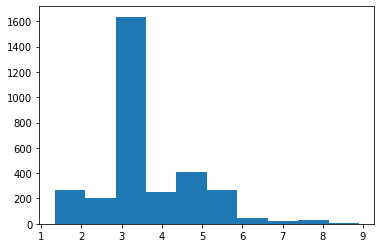

In [159]:
plt.hist(gene_score_data_v1['score_raw'])

In [160]:
len(gene_score_data_v1[gene_score_data_v1['score_raw'] > 6])

77

In [173]:
cri1 = gene_score_data_v1['score_raw'] <= 2.4
cri2 = gene_score_data_v1['score_raw'] > 0
len(gene_score_data_v1[cri1 & cri2])

428

# L1: 6 < x <= max in [5, 6] #about 77
# L2: 5 < x <= 6 in [4, 5] #about 317
# L3: 3.3 < x <= 5 in [3, 4] #about 950
# L4: 2.4 < x <= 3.3 in [2, 3] #about 1367
# L5: 0 < x <= 2.4 in [0, 2] #about 428

In [174]:
# L1 rescaling
upper_b = 6
lower_b = 5
max_val = gene_score_data_v1['score_raw'].max()
min_val = 6
gene_score_data_v1_L1 = gene_score_data_v1[(gene_score_data_v1['score_raw'] <= max_val) & (gene_score_data_v1['score_raw'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_v1_L1['score'] = gene_score_data_v1_L1['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [175]:
# L2 rescaling
upper_b = 5
lower_b = 4
max_val = 6
min_val = 5
gene_score_data_v1_L2 = gene_score_data_v1[(gene_score_data_v1['score_raw'] <= max_val) & (gene_score_data_v1['score_raw'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_v1_L2['score'] = gene_score_data_v1_L2['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [176]:
# L3 rescaling
upper_b = 4
lower_b = 3
max_val = 5
min_val = 3.3
gene_score_data_v1_L3 = gene_score_data_v1[(gene_score_data_v1['score_raw'] <= max_val) & (gene_score_data_v1['score_raw'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_v1_L3['score'] = gene_score_data_v1_L3['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [177]:
# L4 rescaling
upper_b = 3.3
lower_b = 2.4
max_val = 3
min_val = 2
gene_score_data_v1_L4 = gene_score_data_v1[(gene_score_data_v1['score_raw'] <= max_val) & (gene_score_data_v1['score_raw'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_v1_L4['score'] = gene_score_data_v1_L4['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [178]:
# L5 rescaling
upper_b = 2.4
lower_b = 0
max_val = 2
min_val = 0
gene_score_data_v1_L5 = gene_score_data_v1[(gene_score_data_v1['score_raw'] <= max_val) & (gene_score_data_v1['score_raw'] > min_val)].reset_index().drop(['index'], axis = 1)
gene_score_data_v1_L5['score'] = gene_score_data_v1_L5['score_raw'].apply(scale_score, args = (upper_b, lower_b, max_val, min_val))

In [179]:
gene_score_data_v1 = pd.concat([gene_score_data_v1_L1, gene_score_data_v1_L2, gene_score_data_v1_L3, gene_score_data_v1_L4, gene_score_data_v1_L5]).reset_index().drop(['index'], axis = 1)

(array([  93.,  176.,  183., 1725.,  478.,   80.,  224.,   48.,   59.,
          14.]),
 array([1.6 , 2.04, 2.48, 2.92, 3.36, 3.8 , 4.24, 4.68, 5.12, 5.56, 6.  ]),
 <a list of 10 Patch objects>)

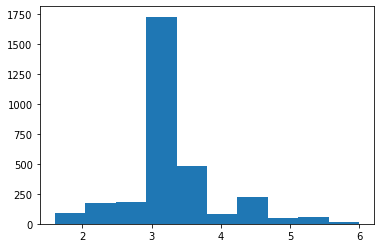

In [181]:
plt.hist(gene_score_data_v1['score'])

In [183]:
gene_score_data_v1['score'].describe()

count    3080.000000
mean        3.358300
std         0.662700
min         1.600000
25%         3.075956
50%         3.300000
75%         3.644323
max         6.000000
Name: score, dtype: float64

In [185]:
gene_score_data_v1.to_excel(r'C:\Users\edwar\Desktop\農藝\paper2\data collection\function_layer_final.xlsx', index = False)